# House Prices - Advanced Regression Techniques

## Deva Kulkarni, Jared Dec, Marc Semonick, Trevor Johnson

## December 2021

<br>

The following report is based on the Kaggle competition: ["House Prices - Advanced Regression Techniques"](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).  In the competition, participants are challenged to predict housing prices in Ames, Iowa based on a dataset complied by [James DeCock](https://http://jse.amstat.org/v19n3/decock.pdf).  The dataset contiains detailed data houses sold in Ames, Iowa between the years 2006 and 2010.  There are up to 80 data points per house, including expected hard data such as square feet for each floor and lot size, as well as some more subjective data like quality and condition.  The **inference problem** that we will attempt to solve in this report is: 

<p style="text-align: center;">Given these data points for a house, predict the sale price of that house.</p>

To guide the reader through our solution to this inference problem, we will divide our approach into three main sections: Exploratory data analysis, feature engineering and model exploration, and our final predictive model.  The final deliverables will be this notebook containing all relevant code and descriptions, as well as a .csv output of our final predictions as required by the Kaggle competition.

# Setups

Import modules.

In [29]:
import os 
import re

# data manipulation/viz
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# modeling setups
from patsy import dmatrices
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler

# linear modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from statsmodels.formula.api import glm 

# tree modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# other
from sklearn.decomposition import PCA

# turn off the df['col'] = x assignment warning
pd.options.mode.chained_assignment = None  # default='warn'

Read in data.

In [30]:
train = pd.read_csv("../../housing_data/train.csv")
test = pd.read_csv("../../housing_data/test.csv")
sample = pd.read_csv("../../housing_data/sample_submission.csv")

Creating functions to clean the data so it could theoretically be used on any new unforseen data.

The na_clean function handles the missing values we've encountered in the data. A few variables such as `PoolQC` and `MiscFeature` had so many missing values that we decided to remove the variable entirely from the dataset. Several other variables had fewer missing values that we've decided to deal with in various ways such as median replacement, zero replacement, or by filling with "missing". 

The standard_feature_eng function simplifies several variables and creates new ones based on the existing variables. We've commented each computation in both functions to explain each step. 

In [31]:
def na_clean(df):
    
    # some vars are just too missing so I remove the field
    df = df.drop(columns = ["PoolQC", "MiscFeature"])

    # replace some numeric vars w/ median
    median_replace_vars = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
    for var in median_replace_vars:
        df[var].fillna(df[var].median(), inplace = True)
    
    # replace some num vars w/ 0
    zero_replace_vars = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']
    for var in zero_replace_vars:
        df[var].fillna(0, inplace = True)
    
    # replace some cat vars w/ most freq value 
    df['MasVnrType'].fillna('None', inplace = True)
    df['Electrical'].fillna('SBrkr', inplace = True)
    df['MSZoning'].fillna('RL', inplace = True)
    df['SaleType'].fillna('WD', inplace = True)
    df['Utilities'].fillna('AllPub', inplace = True)
    df['KitchenQual'].fillna('TA', inplace = True)
    df['Functional'].fillna('Typ', inplace = True)

    # other cat vars just put missing if there isn't a glaring most popular category
    replace_missing_vars = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Exterior1st', 
        'Exterior2nd', 'FireplaceQu']
    for var in replace_missing_vars:
        df[var].fillna("Missing", inplace = True)

    return df



# Function for some standard feature engineering to use in all models
def standard_feature_eng(df, test_data = False):
    '''Input either the training or test data. 
    2nd arg set to True if it's the testing data. That way we ignore the final log transformation on sale price'''

    # num features to just binarize b/c few houses have the feature
    df["SwimmingPool"] = df['PoolArea'].map(lambda x: 0 if x==0 else 1)
    df["3SsnPorch"] = df['3SsnPorch'].map(lambda x: 0 if x==0 else 1)
    df["ScreenPorch"] = df['ScreenPorch'].map(lambda x: 0 if x==0 else 1)

    # re-factoring vars:
    # group the irregularities into 2 factor levels
    df['LotShape'] = df['LotShape'].map({'Reg': 'Reg', 'IR1': 'Reg', 'IR2': 'Irreg', 'IR3': 'Irreg'})

    # simplifying MSSubClass because we have the year built in another feature
    df['MSSubClass'] = df['MSSubClass'].map(lambda x: 
        "1_story"   if (x in (20, 30, 40, 120)) else(
        "1.5_story" if (x in (45, 50, 150)) else(
        "2_story"   if (x in (60, 70, 75, 160, 180, 190)) else(
        "split"     if (x in (80, 85)) else(
        "duplex"    if (x ==90) else(
        "other"))))))
    df['MSSubClass'] = df['MSSubClass'].astype("object")

    # simplifying more vars
    # electrical:
    df['Electrical'] = df['Electrical'].map(lambda x: "SBrkr" if x == "SBrkr" else "Fuse")
    # exterior:
    df['Exterior'] = df['Exterior1st'].map(lambda x: 
        # group exterior into simplified var based on average prices
        "Expensive" if (x in ("VinylSd", "CemntBd", "Stone", "ImStucc")) else(
        "Cheap" if (x in ("BrkComm", "AsphShn", "CBlock", "AsbShng")) else(
        "Moderate")))
    df = df.drop(columns=['Exterior1st', 'Exterior2nd'])
    # garage
    df['GarageQual'] = df['GarageQual'].map(lambda x: 
        # group exterior into simplified var based on average prices
        "Good" if (x in ("Ex", "Gd")) else(
        "Medium" if (x in ("TA")) else(
        "Bad")))
    df['Heating'] = df['Heating'].map(lambda x: "Gas" if x in ("GasA", "GasW") else "Other")

    # deciding to drop a few features for various reasons
    vars_to_drop = [
        # not much variation:
        "LowQualFinSF", 
        "LandSlope", 
        "MiscVal", 
        "RoofMatl",
        "Condition2",
        #"KitchenAbvGr" # hardly any variation. But, Deva included in lm's so including it now.
        "PoolArea", # binarized above
        "Utilities", # only 1 obs in training data different from regular
        "HouseStyle" # already explained in other vars
        ]
    df.drop(columns=vars_to_drop, inplace=True) 

    # adding a remodeled feature
    df['Remodeled'] = (df.YearRemodAdd-df.YearBuilt) == 0

    # total inside area will be a sum of 1st and 2nd floor sq ft
    df['Total_Inside_Area'] = df['1stFlrSF'] + df['2ndFlrSF']
    df.drop(columns = ['1stFlrSF', '2ndFlrSF', 'GrLivArea'], inplace = True)

    # simplify the bathrooms variable
    df['Bathrooms'] = df.BsmtFullBath + 0.5*df.BsmtHalfBath + df.FullBath + 0.5*df.HalfBath
    df.drop(columns = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace = True)

    # get log of sale price which will be our actual response variable
    if test_data:
        pass 
    else:
        
        df['LogSalePrice'] = np.log(df.SalePrice)

    return df


# EDA

See size of the data and check for missing values.

In [19]:
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))
print("\nFeature with missing values:")
train.isnull().sum()[train.isnull().sum() != 0]

Train shape: (1460, 81)
Test shape: (1459, 80)

Feature with missing values:


LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

The response variable, Sale Price, is skewed right with most homes priced between \$100K and \$200K. After taking the log of the Sale Price, the distribution is normally distributed. 

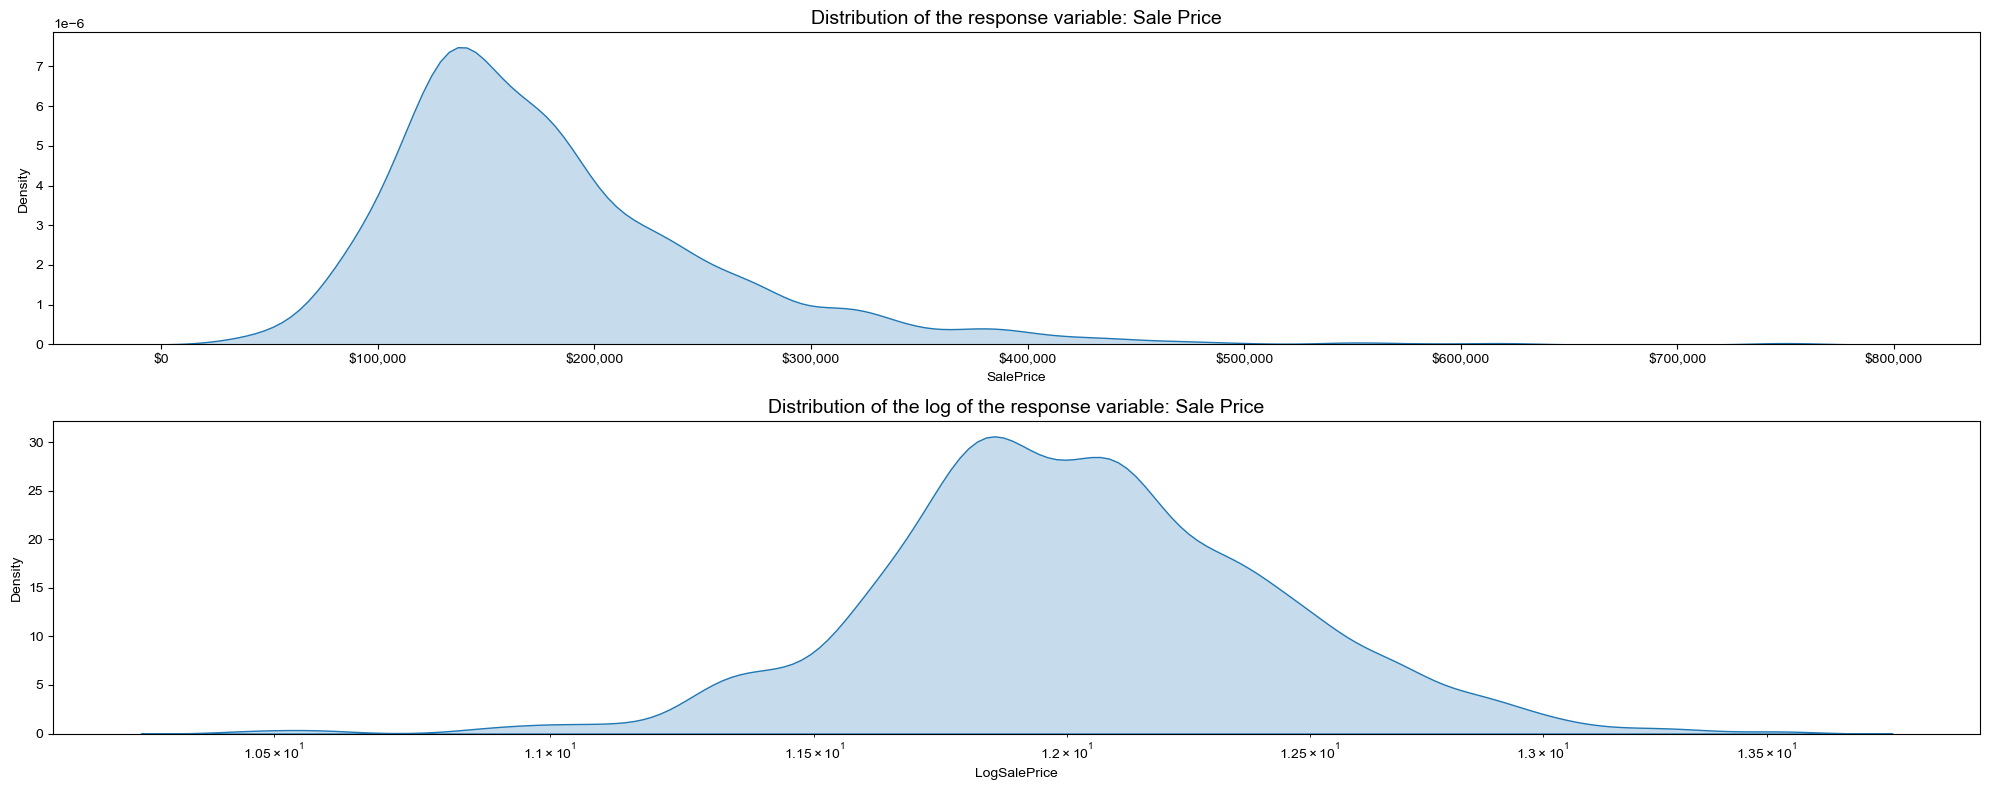

In [20]:
train_log = train.copy()
train_log['LogSalePrice'] = np.log(train_log['SalePrice'])

fig, ax = plt.subplots(2, 1, figsize=(20, 8))
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(ax=ax[0], data=train, x="SalePrice", bw_adjust=.8, fill=True)\
    .set_title("Distribution of the response variable: Sale Price", size=14)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax[0].xaxis.set_major_formatter(tick)

sns.kdeplot(ax=ax[1], data=train_log, x="LogSalePrice", bw_adjust=.8, fill=True, log_scale=True)\
    .set_title("Distribution of the log of the response variable: Sale Price", size=14)

ax[1].xaxis.set_major_formatter(tick)

fig.tight_layout()

The plot below shows the variables that have a correlation above 0.7 with at least one other variable. Many variables are highly correlated with Sale Price such as square feet variables, year built, the number of bedrooms above ground, and garage size. 

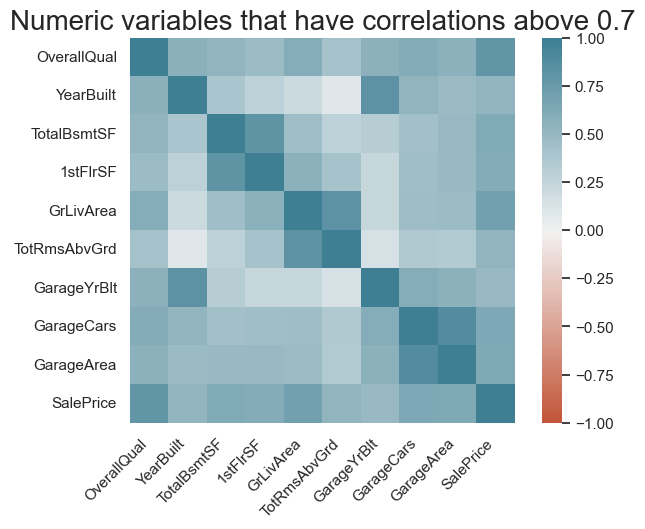

In [38]:
# get correlations of all numeric vars
corr_orig = train.select_dtypes(include=['float', 'int']).corr()

# there are 38 of them, let's look at a subset to only show the ones w/ correlations above some threshold
threshold = .7
bool_list = [sum((corr_orig.iloc[i,:] < 1) & (np.abs(corr_orig.iloc[i,:]) > threshold)) > 0 for i in range(corr_orig.shape[0])]
corr = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))].loc[:, bool_list].corr()

# plot the results
sns.set()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Numeric variables that have correlations above {:.1f}".format(threshold), fontdict = {"fontsize": 20})

plt.gcf().set_size_inches(7, 5)
fig.tight_layout()
print("")

The grid below shows every numeric feature's relationship to the Sale Price. Like the correlation plot above confirms, several variables that represent the square footage of the home have a clear positive relationship with Sale Price. The overall quality of the home also appears to have a strong positive relationship. 

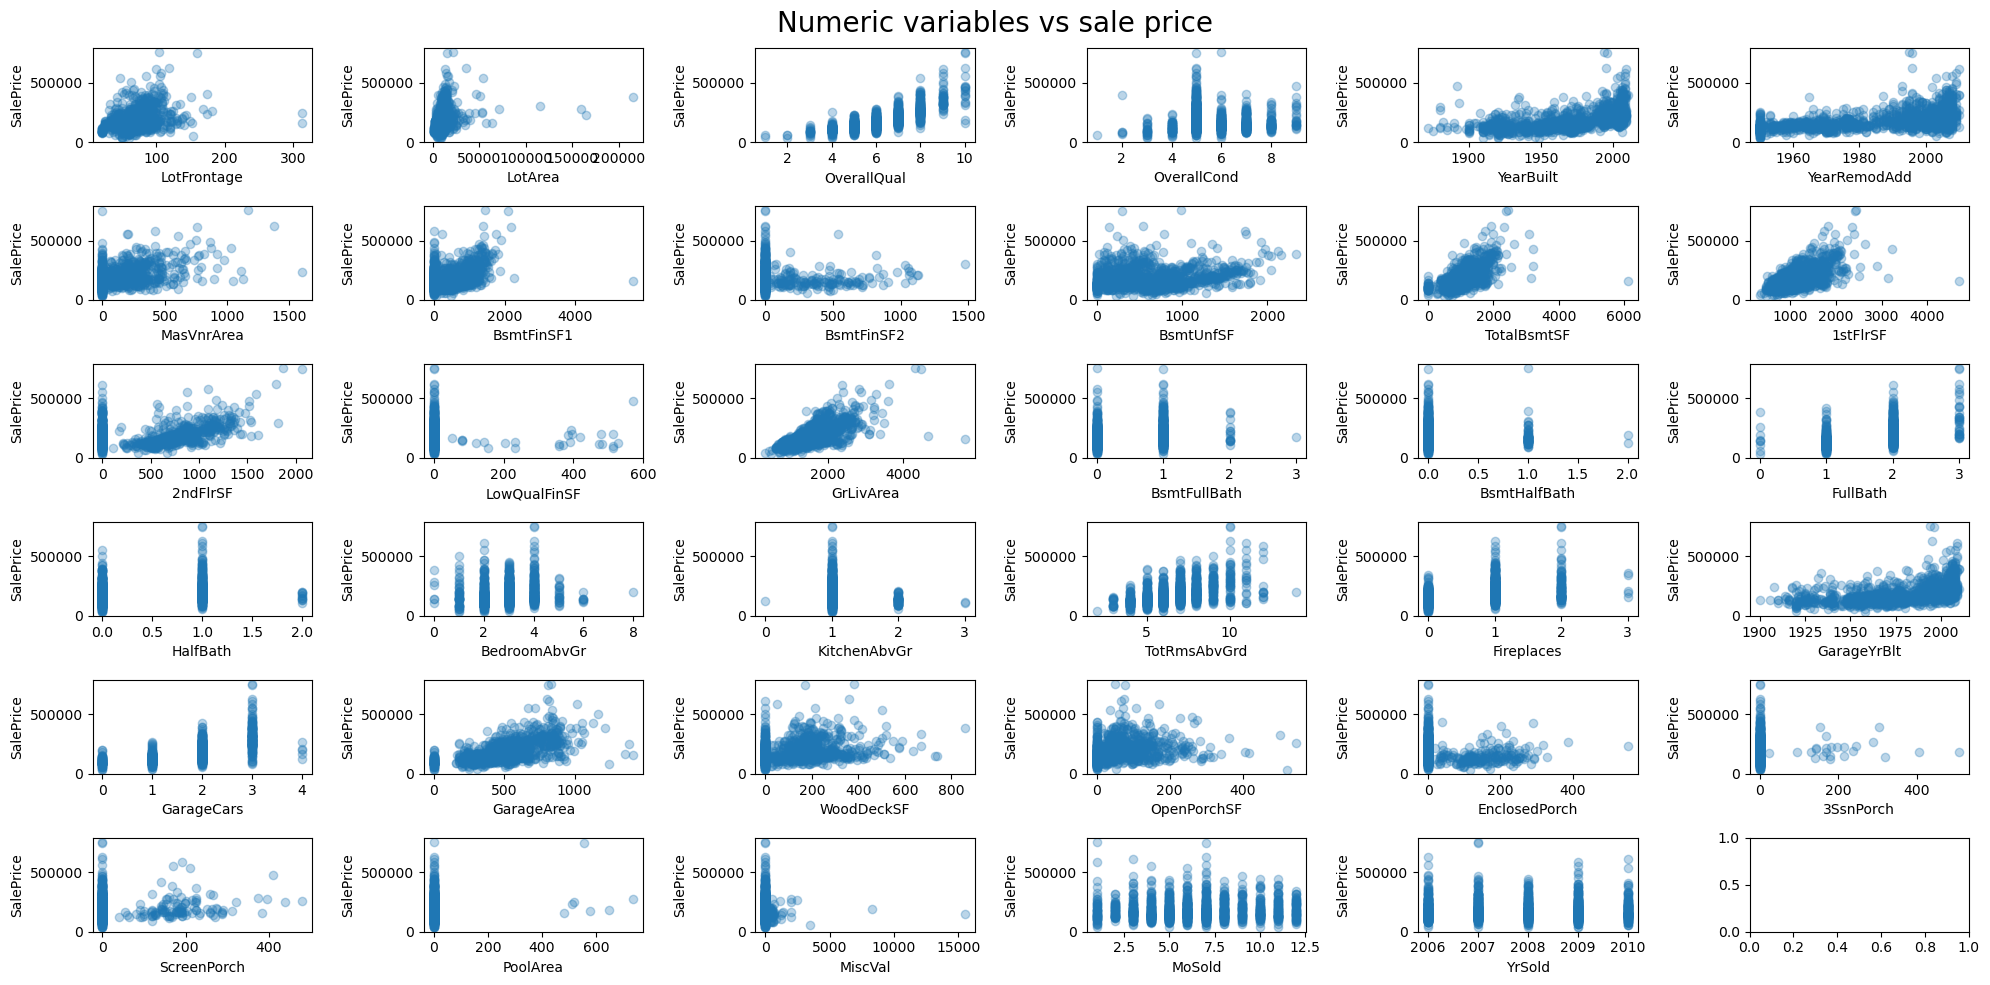

In [22]:
# create dataset for plotting
plot_df = train.drop(columns = ["PoolQC", "MiscFeature", "Id"])
plot_df['MSSubClass'] = plot_df['MSSubClass'].astype('object')

# scatter plots of all num vars w/ response var
num_vars = plot_df.select_dtypes(include=['float', 'int'])

# plot in 6x6 grid to plot the 36 num vars against SalePrice
num_rows = 6
num_cols = 6
plt.style.use('default')
fig, ax = plt.subplots(num_rows, num_cols, figsize = (20, 10))

col_i = 0
for i in range(num_rows):
    for j in range(num_cols):
        if (num_vars.columns[col_i] == "SalePrice"):
            pass 
        else:
            ax[i][j].scatter(num_vars.iloc[:, col_i], num_vars['SalePrice'], alpha = .3)
            ax[i][j].set_xlabel(num_vars.columns[col_i])
            ax[i][j].set_ylabel("SalePrice")
            
            col_i += 1

fig.suptitle("Numeric variables vs sale price".format(col_i), size=20)
fig.tight_layout()
print("")

The next grid shows every categorical feature's relationship to the Sale Price of the home. Each bar shows the average sale price for each factor level of the categorical feature. Several features provide a lot of separation of Sale Price such as MSZoning, neighborhood, condition 1 & 2, and quality variables. 

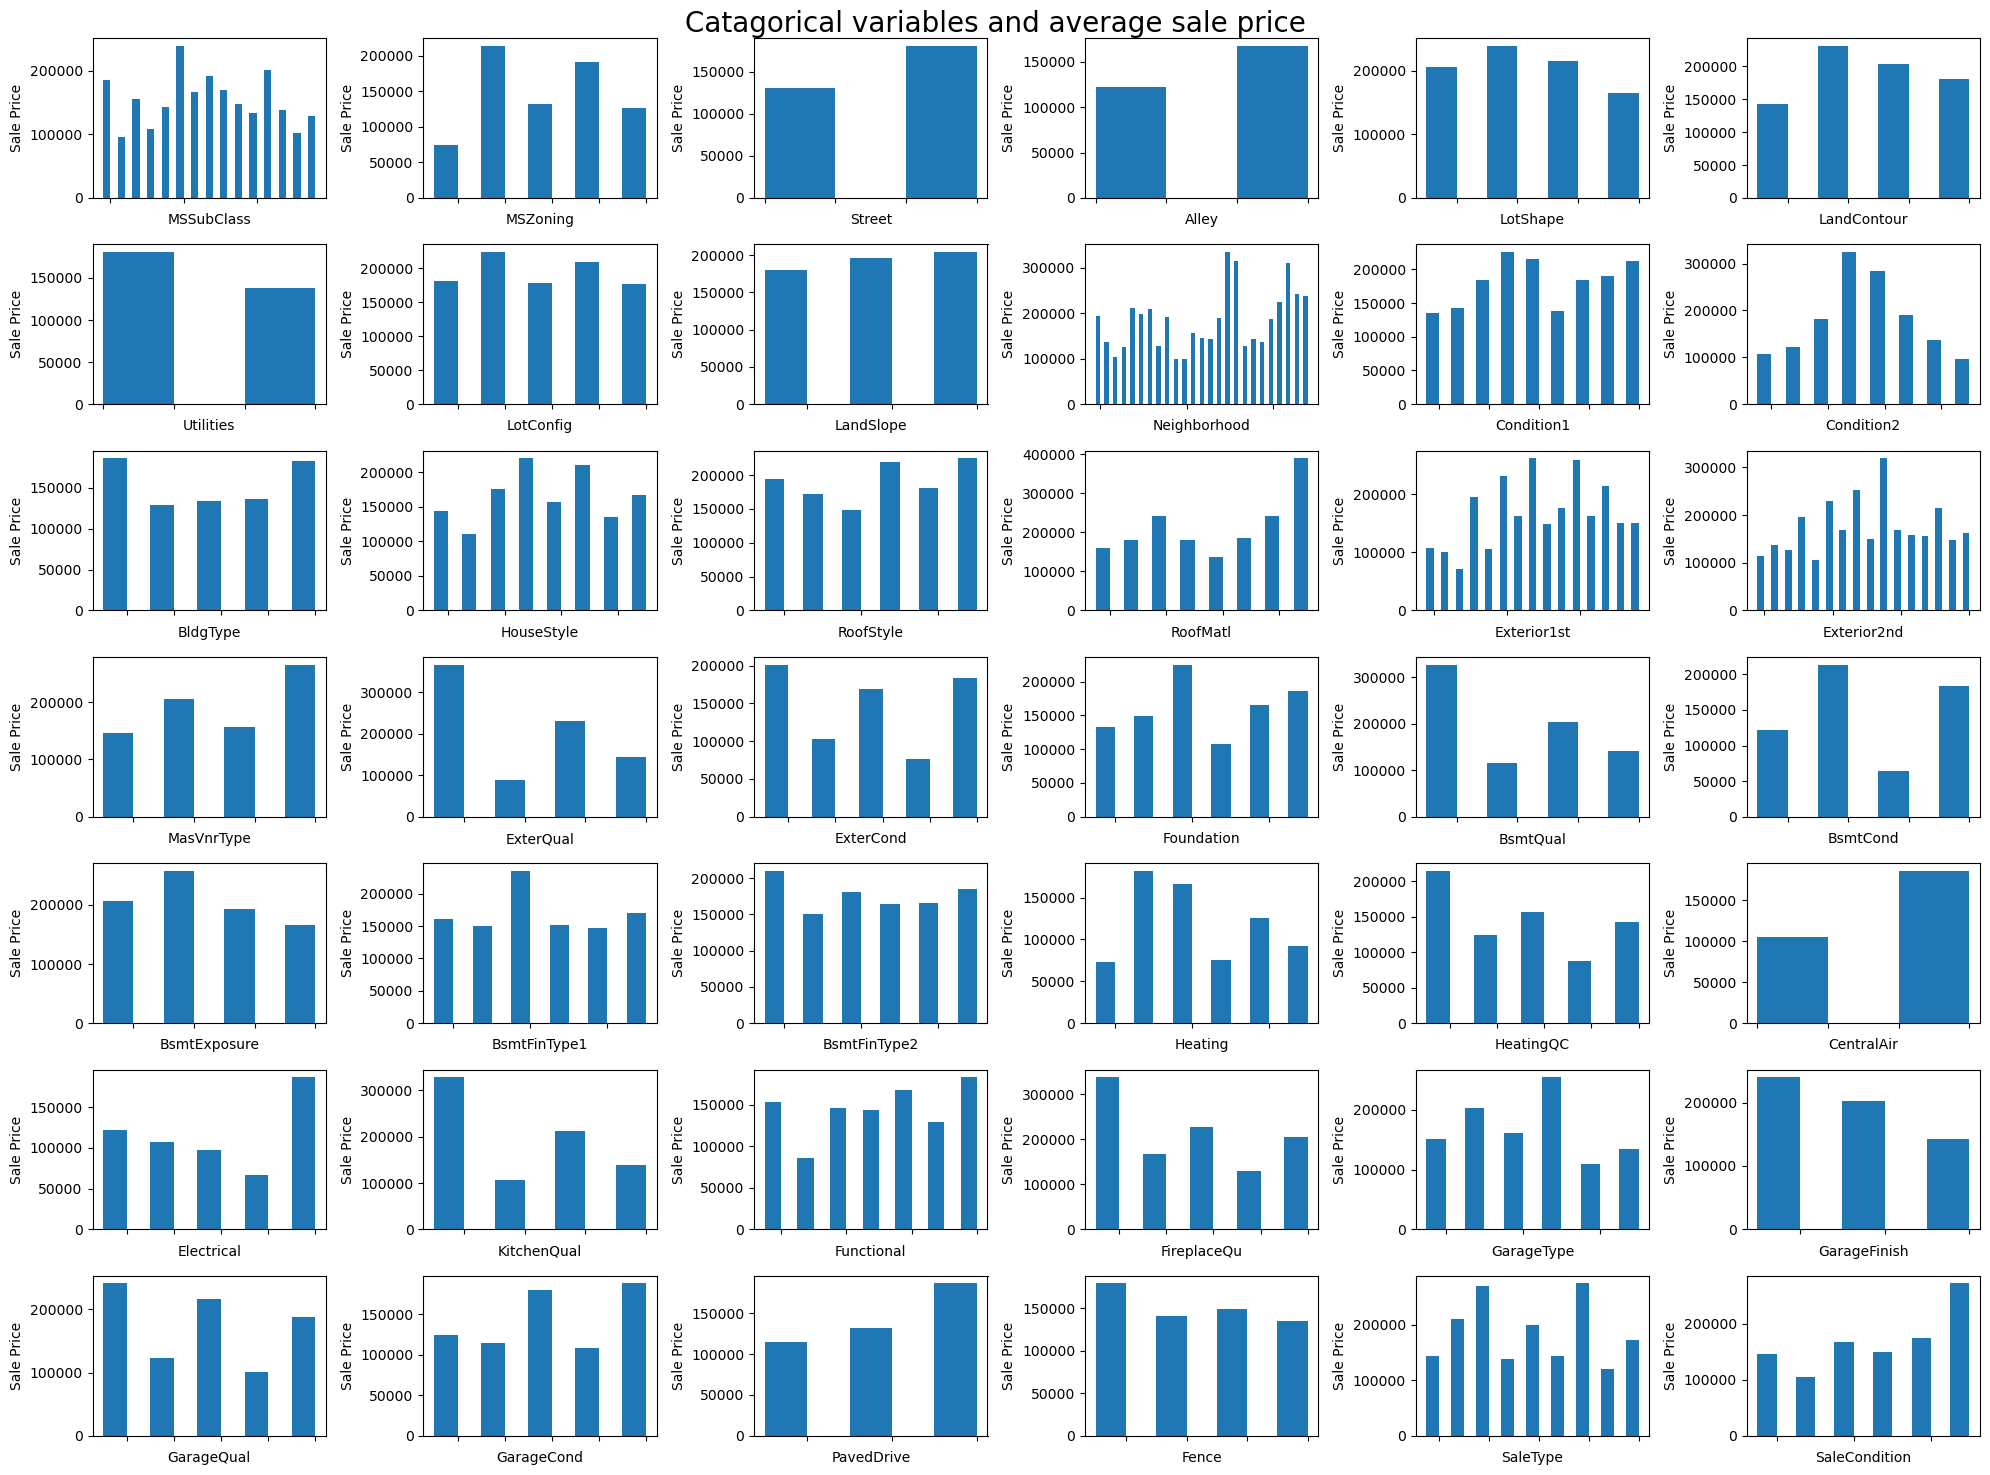

In [23]:
# categorical exploration
cat_vars = pd.concat([plot_df.select_dtypes("object"), train.SalePrice], axis = 1)
n_cols = cat_vars.shape[1]

# plots
num_row = 7
num_col = 6
fig, ax = plt.subplots(num_row, num_col, figsize = (20, 15))

count_k = 0
for i in range(num_row):
    for j in range(num_col):

        # each df
        var_i = cat_vars.columns[count_k]

        if var_i == "SalePrice":
            pass 
        else:

            df_i = pd.DataFrame(cat_vars.groupby(var_i)['SalePrice'].mean())
            df_i.reset_index(inplace = True)

            # create plot i
            x = np.arange(df_i.shape[0])
            width = .5

            # set the bars
            ax[i][j].bar(x - width / 2, df_i.SalePrice, width, label = "x")
            ax[i][j].set_xlabel(var_i)
            ax[i][j].set_ylabel("Sale Price")
            #ax[i][j].set_xticklabels(df_i[var_i], rotation = 90)
            ax[i][j].set_xticklabels("")
            
            count_k += 1

fig.suptitle("Catagorical variables and average sale price", size=20)
fig.tight_layout()

print("")

The histogram below shows the distribution of the home sale price divided by lot area. Most houses are priced between \$10 and \$30 per square foot of lot area. 

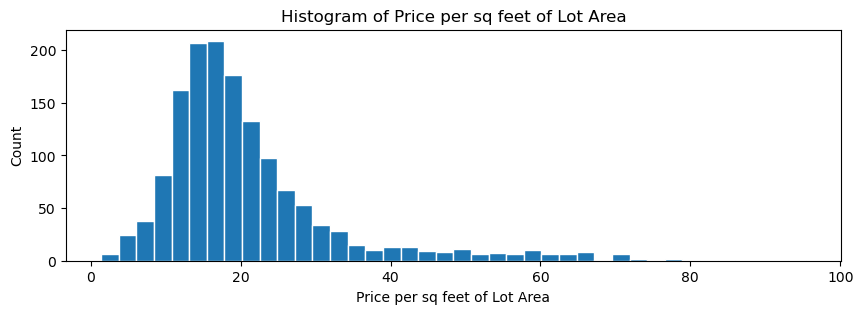

In [24]:
# Looking at price per sq feet of lot area
plot_df.loc[:, 'PricePerSqFeet'] = plot_df.SalePrice/train.LotArea

fig, ax = plt.subplots(figsize = (10, 3))

ax.hist(plot_df.PricePerSqFeet, bins = 40, edgecolor = "white")
ax.set_ylabel('Count')
ax.set_xlabel('Price per sq feet of Lot Area')
ax.set_title('Histogram of Price per sq feet of Lot Area')
print("")

# Ideas based on EDA

### Dividing cheap neighborhoods from expensive neighborhoods

Early on in the error analysis process, it was discovered by our team that our model was poor at predicting prices for houses that tended to be older or cheaper. An early idea for how to separate our data by characteristics like age and price was to separate houses in the data from poor, older neighborhoods with houses in newer neighborhoods that tended to be owned by the more wealthy. Based on exploratory data analysis there is quite a bit of variation between the neighborhoods in the dataset in terms of price, age, and as a result, price per square foot. 

<img src="../images/pca.png" alt="PCA - Neighborhoods" width="50%" height="50%">

In this PCA: SalePrice is the predominant variable in Principal Component 1 (along the x-axis), and the green dots represent neighborhoods that have houses with lower prices per square foot while the red dots represent neighborhoods that have houses with high prices per square foot on average. As one can see, the data appears to visually separable but models that naively flagged houses as being in neighborhoods that were labelled as older and cheaper per square foot and those that were in newer neighborhoods with high costs per square foot, actually performed worse than models where the houses were not separated in such a manner. It appears, as a result that the sale price of houses depend on many factors other than the general characteristics of the neighborhoods in which they are located.

# Final Model

Our final model uses an ensemble of five different regression models: an OLS model with 16 variables, a simple OLS model with one variable, Lasso regression, random forest, and XGBoost. Below, we describe how we build each one. 

## OLS

The inclusion of the simple OLS model in our ensemble is one of the more baffling results of tests of our various model configurations. Its original inclusion in the ensemble model was a simple thought experiment about whether or not our original OLS model contained too many variables, and whether including an OLS model with only a single variable (the single strongest corollary with sale price, the assed overall quality of the property), improved the fit over the more inclusive OLS regression. The result was, to our surprise, that the simple OLS model, as we dubbed it, performed somewhat better than our inclusive OLS. We then tried to adjust the variables included in the OLS regression but for whatever reason even an OLS model with just the two most correlated variables (assessed overall property quality and the square footage of the home) performed worse than the one-variable simple OLS. It should be said that these quality of fits were measured in conjunction with the other models included in the final ensemble and not on their own. It’s not entirely known to us why the inclusion of the simple OLS improves the overall fit so well compared to the more logical inclusive OLS model. It could be that the other models with heavier weights such as random forest and lasso regression are overly complex and overfit the training data. By comparison, simple OLS has an extremely poor fit on training data and perhaps its small weight somewhat improves the overall model by reducing this degree of overfitting. In contrast the more inclusive OLS could be more overfit while also being an inferior predictor compared to Lasso and Random Forest hence why its inclusion actually reduced our ensemble model’s overall performance. 

In [25]:
def lm_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    lm_vars = ['LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearRemodAdd', 
              'BsmtCond', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 
             'MoSold', 'Remodeled', 'Total_Inside_Area', 'Bathrooms', 'GarageCars', 'BsmtFinSF1']
    
    df = pd.get_dummies(df[lm_vars], 
        columns = ['Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'BsmtCond','KitchenQual'], 
        drop_first=True)

    return df


# data setups
X_train = lm_df_clean(train)
X_test = lm_df_clean(test, test_data=True)
Y_train = train.SalePrice
Y_test = sample.SalePrice

# fit to train data
lr_1 = LinearRegression(fit_intercept=True).fit(X_train, Y_train)

# evaluate performance
print("Score on training data: {:.3f}".format(lr_1.score(X_train,Y_train)))
print("Score on testing data: {:.3f}".format(lr_1.score(X_test ,Y_test)))

yhat_train = lr_1.predict(X_train)
yhat_test = lr_1.predict(X_test)

# rmse
rmse_train = (np.mean((np.log(yhat_train) - np.log(Y_train))**2))**.5
rmse_test = (np.mean((np.log(yhat_test) - np.log(Y_test))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 0.859
Score on testing data: -17.901
Log RMSE on training data: 0.141
Log RMSE on testing data: 0.388


An OLS model that only uses the overall quality variable.

In [27]:
# data setup function
def lm_overall_quality_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)
    df = df.loc[:, ['OverallQual']]
    
    return df

# data setups
X_train = lm_overall_quality_df_clean(train)
X_test = lm_overall_quality_df_clean(test, test_data=True)
Y_train = train.SalePrice
Y_test = sample.SalePrice

# fit to train data
lr_overall_quality = LinearRegression(fit_intercept=True).fit(X_train, Y_train)

# Evaluate performance
print("Score on training data: {:.3f}".format(lr_overall_quality.score(X_train,Y_train)))
print("Score on testing data: {:.3f}".format(lr_overall_quality.score(X_test ,Y_test)))

yhat_train = lr_overall_quality.predict(X_train)
yhat_test = lr_overall_quality.predict(X_test)

# set negative values to 0.1
yhat_train = np.array([0.1 if i < 0 else i for i in yhat_train])
yhat_test = [0.1 if i < 0 else i for i in yhat_test]

# rmse
rmse_train = (np.mean((np.log(yhat_train) - np.log(Y_train))**2))**.5
rmse_test = (np.mean((np.log(yhat_test) - np.log(Y_test))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 0.626
Score on testing data: -14.882
Log RMSE on training data: 0.811
Log RMSE on testing data: 1.354


## Lasso

When we first started this project, our team began by looking over quite a few Kaggle submissions that had previously been successful for this particular problem. Early on, it became apparent that one of the most common models employed by previously successful teams was the lasso regression. There are two major benefits of lasso regression over standard OLS for this particular problem. For one, lasso regression does not assume there is no collinearity between the variables in the model. From the very first round of EDA that we conducted, we learned that many of the variables in the dataset are highly correlated including many of the ones which were most correlated with sale price in preliminary tests (for instance the square footage of the lot and the square footage of the house, or overall assessed quality of the property and assessed quality of the kitchen alone). The second major benefit of using lasso regression is it minimizes the amount of feature selection we need to do, as lasso regression can assign weights of 0 to variables that are poorly correlated with the outcome variable. The final dataset we fit through our model has over a hundred variables as we divided up some string categorical variables into binary boolean variables for each possible category, expanding the size of the dataset significantly. These are likely the reasons why Lasso was the best performing of all of the four models that were employed in the final ensemble, and why its weight ended up being so high in the ensemble model. 

However there are still some drawbacks to Lasso regression, particularly its assumption of homoscedasticity of the data. There were around 10 variables that had wide ranges of values and appeared to be particularly heteroscedastic, mostly square footage variables and the sale price of the houses themselves. While the sale price was log-transformed for all models, three additional variables were log-transformed for the lasso regression to more strongly satisfy the homoscedasticity assumption and improve its fit: Basement square footage, lotare square footage, and basement square footage. All of the potential candidates were tested and while performing log transformations on most of them did not make the model significantly worse, only those which decreased RMSE on the testing data were kept in the final model.  

Further improvements to the lasso regression’s fit were teased out by changing the alpha hyperparameter. Based on a series of experiments it became apparent that lower alpha values generally caused the fit of the model to improve, hence why the final alpha value is a very low 0.000001.

In [32]:
# first build one hot encoder based on the training data
train_lasso = standard_feature_eng(na_clean(train))
enc_lasso = OneHotEncoder(handle_unknown = 'ignore')
enc_lasso.fit(train_lasso.select_dtypes(include=["object"]))
one_hot_columns = pd.get_dummies(train_lasso.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

# data setup function
def lasso_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    
    df = standard_feature_eng(df, test_data = test_data)
    
    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_lasso.transform(df.select_dtypes(include=["object"])).toarray())
    
    categorical_cols.columns = one_hot_columns
    
    df = df.reset_index().drop(columns='index')
    categorical_cols = categorical_cols.reset_index().drop(columns='index')
    
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # log transformations
    #df["GrLivArea"] = np.log(df["GrLivArea"])
    df.Total_Inside_Area = np.log(df.Total_Inside_Area)
    df.LotArea = np.log(df.LotArea)
    for x in range(len(df.BsmtFinSF1)):
        if df['BsmtFinSF1'][x] ==0:
            df['BsmtFinSF1'][x] = 1
    df.BsmtFinSF1 = np.log(df.BsmtFinSF1)
    
    # select only vars needed
    if test_data:
        df = df.drop(columns=["Id"])
    else:
        df = df.drop(columns=["Id"])
        df['SalePrice'] = np.log(df['SalePrice'])
    
    return df


# data setups
X_train = lasso_df_clean(train)
X_test = lasso_df_clean(test, test_data=True)
Y_train = X_train.SalePrice
X_train = X_train.drop(columns=['LogSalePrice', 'SalePrice'])
Y_test = np.log(sample.SalePrice)


# fit to train data
lasso_fit = Lasso(alpha=0.000001).fit(X_train, Y_train)


# Evaluate performance
yhat_train = lasso_fit.predict(X_train)
yhat_test = lasso_fit.predict(X_test)

# Evaluate performance
print("Score on training data: {:.3f}".format(lasso_fit.score(X_train,Y_train)))
print("Score on testing data: {:.3f}".format(lasso_fit.score(X_test ,Y_test)))

# rmse
rmse_train = (np.mean((yhat_train - np.log(train.SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 0.930
Score on testing data: -17.705
Log RMSE on training data: 0.105
Log RMSE on testing data: 0.389


/Users/tj/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4450840626190065, tolerance: 0.023280065898865106
  model = cd_fast.enet_coordinate_descent(


## Random Forest

Trevor to add comentary (explain hyper parameter tuning).

In [33]:
# first build one hot encoder based on the training data
train_rf = standard_feature_eng(na_clean(train))
enc_rf = OneHotEncoder(handle_unknown = 'ignore')
enc_rf.fit(train_rf.select_dtypes(include=["object"]))
one_hot_columns = pd.get_dummies(train_rf.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

# Random forest data clean function
def rf_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_rf.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_columns
    
    #df = df.reset_index().drop(columns='index')
    #categorical_cols = categorical_cols.reset_index().drop(columns='index')
    
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # drop irrelevant columns
    df = df.drop(columns=["Id"])
    
    return df


# preprocess the data
df_rf = rf_df_clean(train)
df_rf_test = rf_df_clean(test, test_data=True)

# run model on best parameters
rf_reg = RandomForestRegressor(
    n_estimators = 900,
    max_depth = 25,
    max_features = 'auto',
    min_samples_split = 2,  
    bootstrap = True, 
    )

# fit the model
rf_reg = rf_reg.fit(df_rf.drop(columns = ["SalePrice", 'LogSalePrice']), df_rf.LogSalePrice)

# Evaluate performance
yhat_train = rf_reg.predict(df_rf.drop(columns = ["SalePrice", 'LogSalePrice']))
yhat_test = rf_reg.predict(df_rf_test)

# Evaluate performance
print("Score on training data: {:.3f}".format(rf_reg.score(df_rf.drop(columns = ["SalePrice", 'LogSalePrice']), df_rf.LogSalePrice)))
print("Score on testing data: {:.3f}".format(rf_reg.score(df_rf_test, np.log(sample.SalePrice))))

# rmse
rmse_train = (np.mean((yhat_train - np.log(train.SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 0.984
Score on testing data: -15.383
Log RMSE on training data: 0.051
Log RMSE on testing data: 0.364


## XGBoost

Trevor to add comentary

In [34]:
# first build one hot encoder based on the training data
train_xgb = standard_feature_eng(na_clean(train))
enc_xgb = OneHotEncoder(handle_unknown = 'ignore')
enc_xgb.fit(train_xgb.select_dtypes(include=["object"]))
one_hot_columns_xgb = pd.get_dummies(train_xgb.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

# xgboost data clean function
def xgb_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_xgb.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_columns_xgb
    
    #df = df.reset_index().drop(columns='index')
    #categorical_cols = categorical_cols.reset_index().drop(columns='index')
    
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # DO MORE FEATURE ENGINEERING HERE LATER
    df = df.drop(columns = ['Id'])
    
    return df


# preprocess the data
df_xgb = xgb_df_clean(train)
df_xgb_test = xgb_df_clean(test, test_data=True)

# final hyper params
xgb_reg = xgb.XGBRegressor(
    booster="gbtree",
    verbosity=0,
    subsample=.5,  
    colsample_bytree=.7, 
    random_state=1,

    n_estimators=500, 
    max_depth=20,
    learning_rate=.05, 
    reg_alpha=.01, 
    reg_lambda=0.1
)

# fit model
xgb_reg.fit(df_xgb.drop(columns=['SalePrice', 'LogSalePrice']), df_xgb['LogSalePrice'])

# performance on train/test
yhat_train = xgb_reg.predict(df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']))
yhat_test = xgb_reg.predict(df_xgb_test)

# Evaluate performance
print("Score on training data: {:.3f}".format(xgb_reg.score(df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']), df_xgb.LogSalePrice)))
print("Score on testing data: {:.3f}".format(xgb_reg.score(df_xgb_test, np.log(sample.SalePrice))))

# rmse
rmse_train = (np.mean((yhat_train - np.log(train.SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 1.000
Score on testing data: -17.586
Log RMSE on training data: 0.001
Log RMSE on testing data: 0.388


## Ensemble Weights and Final Model Assembly

This section is where all of the previously shown models are combined into a single ensemble model. Essentially all of the models generate predicted outputs in terms of log of sale price for the test data, so all of these outputs are then raised as powers of e to convert them back to untransformed sale prices. Then each of the predicted sale prices for each model are then multiplied by a weight to combine all of the model results into a final prediction. It was not immediately clear to the team which combination of models would produce the best results. Initially all five models: Inclusive OLS, Simple OLS, Lasso, Random Forest, and Boosted Trees, were all given equal weight. Over 50 different combinations of weights were tested before we settled on this final configuration which produced the most optimal results. Deciding which models to give which weights eventually became a game of guess and check after some time. The RMSE on both train and test were poor predictors of which configuration of models would perform the best on the unseen test data. The following is a plot of some of these configurations’ RSME on the train data and test data compared to the unseen test data that the Kaggle score was assessed on:

<img src="../images/rmse_train.png" alt="rmse_train" width="50%" height="50%">

<img src="../images/rmse_test.png" alt="rmse_test" width="50%" height="50%">

The final configuration with the best results consisted of the following weights:

- Inclusive OLS: 0%
- Simple OLS: 7.5%
- Lasso: 57.5%
- Random Forest: 30%
- XGBoost: 5%

It’s difficult to know exactly why this configuration is the best. As stated previously in each of their respective sections, there are pros and cons to each model, and it’s likely that for whatever reason this system of weights produces the best results by counterbalancing each of these various pros and cons. As stated previously Lasso is likely the best fit and consequently the heaviest weight because of the lack of a no collinearity assumption and the fact that it can filter out less helpful variables by allowing weights of variables to go to 0. [INSET THOUGHTS ON RANDOM FOREST AND OTHER MODELS AFTER THOSE SECTIONS ARE WRITTEN].

In [40]:
def housing_ensemble_model(df):
    '''This is the final model that takes in raw data, and makes predictions'''

    # OLS
    yhat_ols1 = lr_1.predict(lm_df_clean(df, test_data=True))

    # OLS Simple
    yhat_ols_simple = lr_overall_quality.predict(lm_overall_quality_df_clean(df, test_data=True))

    # GLM

    # Lasso
    lasso_data = lasso_df_clean(df, test_data=True)
    yhat_lasso = np.exp(lasso_fit.predict(lasso_data))

    # Random forest
    yhat_rf = np.exp(rf_reg.predict(rf_df_clean(df, test_data=True)))

    # XGB
    xgb_data = xgb_df_clean(df, test_data=True)
    yhat_xgb = np.exp(xgb_reg.predict(xgb_data))

    # make ensemble prediction
    # Do more work to come up w/ weights. This is just a sample
    yhat_final = yhat_ols1*(0) + yhat_ols_simple * (0.075) + yhat_lasso * (0.575) + yhat_rf * (0.3) + yhat_xgb * (0.05)

    return yhat_final


# final ensemble model RMSE
yhat_train = housing_ensemble_model(train.drop(columns = ["SalePrice"]))
yhat_test = housing_ensemble_model(test)

rmse_train = np.mean((train.SalePrice - yhat_train)**2)**.5
rmse_test = np.mean((sample.SalePrice - yhat_test)**2)**.5

# evaluate rmse  on the testing data
print("RMSE Train: {:.2f}".format(rmse_train))
print("RMSE Test: {:.2f}".format(rmse_test))

# log results
rmse_train_log = np.mean((np.log(train.SalePrice) - np.log(yhat_train))**2)**.5
rmse_test_log = np.mean((np.log(sample.SalePrice) - np.log(yhat_test))**2)**.5
# evaluate rmse  on the testing data
print("\nLog RMSE Train: {:.5f}".format(rmse_train_log))
print("Log RMSE Test: {:.5f}".format(rmse_test_log))

RMSE Train: 18180.80
RMSE Test: 70337.17

Log RMSE Train: 0.08368
Log RMSE Test: 0.37460


Kaggle Score: 0.12328

Rank: 612 / 4770 = 12.8%

## Conclusion

Scoring the output of our final model on Kaggle, we received an RMSE of 0.12328. Kaggle uses a 2-month rolling leaderboard for this open competition, and this score put us into a position of 654 out of 4917 active competitors.  Based on that ranking, we feel that while we have created a strong model, there is clearly some room for improvement.  

The process highlighted some very important steps for creating a model that performs well on this type of complex data set.  

* For one, it is important to have a good understanding of the data itself.  A thorough EDA allowed us to understand and eliminate variables with a strong colinearity.  It also allowed us to transform variables into something more useful, such as aggregating all of the square footage values, or simple log transformations for a more normal distribution. We spent a lot of time exploring which variables led to valuable insights into the dat.  Some were surprising, such as a subjective measure like Overall Quality.  

* Second, we went down a lot of paths that ended up not bearing fruit.  For example, we explored pre-modeling the neighborhoods into various divisions of expensive and inexpensive, but were unable to get this to lead to any measurable improvement ino the final result.  We also toyed with a lot of data transformations that were ultimately ineffective. However, the explorations were necessary and worthwhile since we needed to answer those questions to move forward.  

* There were many iterations of fine-tuning the final ensemble model with the right weights of each model.  In our experience the right balance was not intuitive, and really just came down to a lot of trial-and-error.  However, this trial-and-error process did ultimately make some of our most significant gains in performance as we narrowed down to our final RMSE score.


[not complete yet]